In [1]:
"""
@author: Maziar Raissi
"""

import sys
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time

np.random.seed(1234)
tf.set_random_seed(1234)

In [2]:
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, X, u, layers, lb, ub):
        
        self.lb = lb
        self.ub = ub
        
        self.x = X[:,0:1]
        self.t = X[:,1:2]
        self.u = u
        
        self.layers = layers
        
        # Initialize NNs
        self.weights, self.biases = self.initialize_NN(layers)
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        # Initialize parameters
        self.lambda_1 = tf.Variable([0.0], dtype=tf.float32)
        self.lambda_2 = tf.Variable([-6.0], dtype=tf.float32)
        
        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]])
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        self.u_tf = tf.placeholder(tf.float32, shape=[None, self.u.shape[1]])
                
        self.u_pred = self.net_u(self.x_tf, self.t_tf)
        self.f_pred = self.net_f(self.x_tf, self.t_tf)
        
        self.loss = tf.reduce_mean(tf.square(self.u_tf - self.u_pred)) + \
                    tf.reduce_mean(tf.square(self.f_pred))
        
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})
    
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
            
    def net_u(self, x, t):  
        u = self.neural_net(tf.concat([x,t],1), self.weights, self.biases)
        return u
    
    def net_f(self, x, t):
        lambda_1 = self.lambda_1        
        lambda_2 = tf.exp(self.lambda_2)
        u = self.net_u(x,t)
        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
        u_xx = tf.gradients(u_x, x)[0]
        f = u_t + lambda_1*u*u_x - lambda_2*u_xx
        
        return f
    
    def callback(self, loss, lambda_1, lambda_2):
        print('Loss: %e, l1: %.5f, l2: %.5f' % (loss, lambda_1, np.exp(lambda_2)))
        
        
    def train(self, nIter):
        tf_dict = {self.x_tf: self.x, self.t_tf: self.t, self.u_tf: self.u}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                lambda_1_value = self.sess.run(self.lambda_1)
                lambda_2_value = np.exp(self.sess.run(self.lambda_2))
                print('It: %d, Loss: %.3e, Lambda_1: %.3f, Lambda_2: %.6f, Time: %.2f' % 
                      (it, loss_value, lambda_1_value, lambda_2_value, elapsed))
                start_time = time.time()
        
        self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss, self.lambda_1, self.lambda_2],
                                loss_callback = self.callback)
        
        
    def predict(self, X_star):
        
        tf_dict = {self.x_tf: X_star[:,0:1], self.t_tf: X_star[:,1:2]}
        
        u_star = self.sess.run(self.u_pred, tf_dict)
        f_star = self.sess.run(self.f_pred, tf_dict)
        
        return u_star, f_star

In [3]:
nu = 0.01/np.pi

N_u = 2000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

data = scipy.io.loadmat('burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)    

######################################################################
######################## Noiseles Data ###############################
######################################################################
noise = 0.0            

idx = np.random.choice(X_star.shape[0], N_u, replace=False)
X_u_train = X_star[idx,:]
u_train = u_star[idx,:]

model = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)
model.train(0)

u_pred, f_pred = model.predict(X_star)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')

lambda_1_value = model.sess.run(model.lambda_1)
lambda_2_value = model.sess.run(model.lambda_2)
lambda_2_value = np.exp(lambda_2_value)

error_lambda_1 = np.abs(lambda_1_value - 1.0)*100
error_lambda_2 = np.abs(lambda_2_value - nu)/nu * 100

print('Error u: %e' % (error_u))    
print('Error l1: %.5f%%' % (error_lambda_1))                             
print('Error l2: %.5f%%' % (error_lambda_2))  

######################################################################
########################### Noisy Data ###############################
######################################################################
noise = 0.01        
u_train = u_train + noise*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])

model = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)
model.train(10000)

u_pred, f_pred = model.predict(X_star)

lambda_1_value_noisy = model.sess.run(model.lambda_1)
lambda_2_value_noisy = model.sess.run(model.lambda_2)
lambda_2_value_noisy = np.exp(lambda_2_value_noisy)

error_lambda_1_noisy = np.abs(lambda_1_value_noisy - 1.0)*100
error_lambda_2_noisy = np.abs(lambda_2_value_noisy - nu)/nu * 100

print('Error lambda_1: %f%%' % (error_lambda_1_noisy))
print('Error lambda_2: %f%%' % (error_lambda_2_noisy))                           


2023-11-25 20:01:08.538625: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2023-11-25 20:01:08.554258: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
2023-11-25 20:01:08.563641: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x556bf63a9440 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-11-25 20:01:08.563678: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-11-25 20:01:08.566915: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:1 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:2 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:3 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: Tesla V100-PCIE-32GB, pci bus id: 0000:5e:00.0, compute capability: 7.0
/job:localhost/replica:0/task:0/device:GPU:2 -> device: 2, name: Tesla V100-PCIE-32GB, pci bus id: 0000:86:00.0, compute capability: 7.0
/job:localhost/replica:0/task:0/device:GPU:3 -> device: 3, name: Tesla V100-PCIE-32GB, pci bus id: 0000:af:00.0, compute capability: 7.0




2023-11-25 20:01:09.106898: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x556bf64089a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-25 20:01:09.106937: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2023-11-25 20:01:09.106946: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): Tesla V100-PCIE-32GB, Compute Capability 7.0
2023-11-25 20:01:09.106952: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): Tesla V100-PCIE-32GB, Compute Capability 7.0
2023-11-25 20:01:09.106958: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (3): Tesla V100-PCIE-32GB, Compute Capability 7.0
2023-11-25 20:01:09.123248: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla V100-PCIE-32GB major: 7 minor: 0 memoryClockRate(GHz): 1.38
pciBusID:

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:1 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:2 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:3 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: Tesla V100-PCIE-32GB, pci bus id: 0000:5e:00.0, compute capability: 7.0
/job:localhost/replica:0/task:0/device:GPU:2 -> device: 2, name: Tesla V100-PCIE-32GB, pci bus id: 0000:86:00.0, compute capability: 7.0
/job:localhost/replica:0/task:0/device:GPU:3 -> device: 3, name: Tesla V100-PCIE-32GB, pci bus id: 0000:af:00.0, compute capability: 7.0
truncated_normal/TruncatedNormal: (TruncatedNormal): /job:loc

2023-11-25 20:01:12.369263: I tensorflow/core/common_runtime/placer.cc:54] truncated_normal/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-25 20:01:12.369309: I tensorflow/core/common_runtime/placer.cc:54] truncated_normal/mul: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-25 20:01:12.369324: I tensorflow/core/common_runtime/placer.cc:54] truncated_normal: (Add): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-25 20:01:12.369335: I tensorflow/core/common_runtime/placer.cc:54] Variable: (VariableV2): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-25 20:01:12.369349: I tensorflow/core/common_runtime/placer.cc:54] Variable/Assign: (Assign): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-25 20:01:12.369360: I tensorflow/core/common_runtime/placer.cc:54] Variable/read: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-25 20:01:12.369371: I tensorflow/core/common_runtime/placer.cc:54] Variable_1: (Variabl

Loss: 3.949373e-01, l1: 0.00000, l2: 0.00248
Loss: 7.736641e-01, l1: 0.00000, l2: 0.00248
Loss: 3.374787e-01, l1: 0.00000, l2: 0.00248
Loss: 2.880107e-01, l1: 0.00016, l2: 0.00248
Loss: 8.284903e+00, l1: 0.00138, l2: 0.00248
Loss: 2.714846e-01, l1: 0.00022, l2: 0.00248
Loss: 2.565791e-01, l1: 0.00035, l2: 0.00248
Loss: 2.386289e-01, l1: 0.00033, l2: 0.00248
Loss: 2.358943e-01, l1: 0.00035, l2: 0.00248
Loss: 2.344091e-01, l1: 0.00035, l2: 0.00248
Loss: 2.298072e-01, l1: 0.00035, l2: 0.00248
Loss: 2.098744e-01, l1: 0.00028, l2: 0.00248
Loss: 2.486425e-01, l1: -0.00004, l2: 0.00248
Loss: 1.964646e-01, l1: 0.00017, l2: 0.00248
Loss: 1.716977e-01, l1: 0.00061, l2: 0.00248
Loss: 1.127574e-01, l1: 0.00481, l2: 0.00248
Loss: 1.011978e-01, l1: 0.01674, l2: 0.00247
Loss: 9.693929e-02, l1: 0.02580, l2: 0.00247
Loss: 9.442842e-02, l1: 0.03721, l2: 0.00247
Loss: 8.519816e-02, l1: 0.10103, l2: 0.00244
Loss: 3.229343e-01, l1: 0.41732, l2: 0.00231
Loss: 7.502510e-02, l1: 0.18145, l2: 0.00241
Loss: 1.5

INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  Objective function value: 0.000001
  Number of iterations: 5667
  Number of functions evaluations: 6175


Error u: 1.897842e-03
Error l1: 0.03659%
Error l2: 0.59348%
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:1 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:2 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:3 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: Tesla V100-PCIE-32GB, pci bus id: 0000:5e:00.0, compute capability: 7.0
/job:localhost/replica:0/task:0/device:GPU:2 -> device: 2, name: Tesla V100-PCIE-32GB, pci bus id: 0000:86:00.0, compute capability: 7.0
/job:localhost/replica:0/task:0/device:GPU:3 -> device: 3, name: Tesla V100-PCIE-32GB, pci bus id:st/replica:0/task:0/device:GPU:0
Variabl

2023-11-25 20:02:08.125983: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla V100-PCIE-32GB major: 7 minor: 0 memoryClockRate(GHz): 1.38
pciBusID: 0000:3b:00.0
2023-11-25 20:02:08.127056: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 1 with properties: 
name: Tesla V100-PCIE-32GB major: 7 minor: 0 memoryClockRate(GHz): 1.38
pciBusID: 0000:5e:00.0
2023-11-25 20:02:08.128105: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 2 with properties: 
name: Tesla V100-PCIE-32GB major: 7 minor: 0 memoryClockRate(GHz): 1.38
pciBusID: 0000:86:00.0
2023-11-25 20:02:08.129116: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 3 with properties: 
name: Tesla V100-PCIE-32GB major: 7 minor: 0 memoryClockRate(GHz): 1.38
pciBusID: 0000:af:00.0
2023-11-25 20:02:08.129221: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
20

7.0
/job:localhost/replica:0/task:0/device:GPU:3 -> device: 3, name: Tesla V100-PCIE-32GB, pci bus id: 0000:af:00.0, compute capability: 7.0
truncated_normal/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:GPU:0
truncated_normal/mul: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
truncated_normal: (Add): /job:localhost/replica:0/task:0/device:GPU:0
Variable: (VariableV2): /job:localhost/replica:0/task:0/device:GPU:0
Variable/Assign: (Assign): /job:localhost/replica:0/task:0/device:GPU:0
Variable/read: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
Variable_1: (VariableV2): /job:localhost/replica:0/task:0/device:GPU:0
Variable_1/Assign: (Assign): /job:localhost/replica:0/task:0/device:GPU:0
Variable_1/read: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
truncated_normal_1/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:GPU:0
truncated_normal_1/mul: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
truncated

INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  Objective function value: 0.000037
  Number of iterations: 2957
  Number of functions evaluations: 3189


Error lambda_1: 0.159413%
Error lambda_2: 0.167782%


In [6]:
def figsize(scale, nplots=1):
    fig_width_pt = 390.0  # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0 / 72.27  # Convert pt to inch

    # Aesthetic ratio (you could change this)
    golden_mean = (np.sqrt(5.0) - 1.0) / 2.0

    fig_width = fig_width_pt * inches_per_pt * scale  # width in inches
    fig_height = nplots * fig_width * golden_mean  # height in inches
    fig_size = [fig_width, fig_height]
    return fig_size

def newfig(width, nplots=1):
    # fig = plt.figure(figsize=figsize(width, nplots)) #latex
    fig = plt.figure()
    ax = fig.add_subplot(111)
    return fig, ax

Text(0.5, 1.0, '$t = 0.75$')

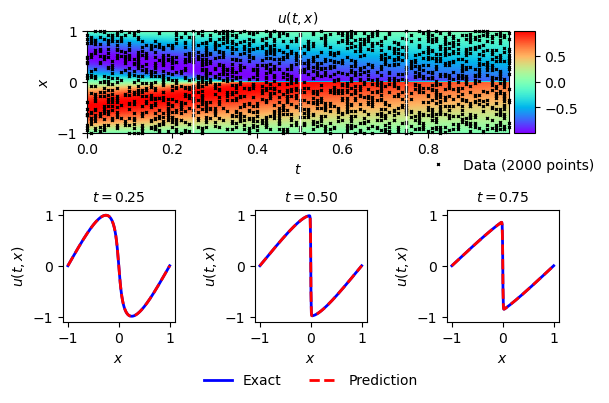

In [7]:
my_rc_param = {'text.usetex': False}
plt.rcParams.update(my_rc_param)

######################################################################
############################# Plotting ###############################
######################################################################    

fig, ax = newfig(1.0, 1.4)
ax.axis('off')

####### Row 0: u(t,x) ##################    
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1.0/3.0+0.06, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 2, clip_on = False)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.legend(loc='upper center', bbox_to_anchor=(1.0, -0.125), ncol=5, frameon=False)
ax.set_title('$u(t,x)$', fontsize = 10)

####### Row 1: u(t,x) slices ##################    
gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 10)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 10)